In [2]:
import numpy as np
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sb
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
%matplotlib inline


C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df_amazon = pd.read_csv('amazon_cells_labelled.txt', header=None, delimiter='\t', names=['txt', 'sentiment'])
df_amazon

,txt,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [4]:
# load the titanic dataset
df_titanic = pd.read_csv(r'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
### Tasks
# 1. What was the average age of the Titacic passengers?
# 2. What is the survival ratio of for each passenger class in the Titanic? 
# 3. Is the survival ratio of young people (20y or less) higher than older people (30+)?

# 4. Build two wordclouds, one for good amazon reviews and one for bad reviews
# 5. Build classifier for Amazon reviews sentiment prediction that has an accuracy better of 0.74 or more.

# Solutions

### 1. Create a stemmed version of the text

In [3]:
porterStemmer = PorterStemmer()
df['stemmed_txt'] = df['txt'].apply(lambda x: ' '.join([porterStemmer.stem(word) for word in word_tokenize(x)]))
df

,txt,sentiment,stemmed_txt
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,"good case , excel valu ."
2,Great for the jawbone.,1,great for the jawbon .
3,Tied to charger for conversations lasting more...,0,tie to charger for convers last more than 45 m...
4,The mic is great.,1,the mic is great .
...,...,...,...
995,The screen does get smudged easily because it ...,0,the screen doe get smudg easili becaus it touc...
996,What a piece of junk.. I lose more calls on th...,0,what a piec of junk .. i lose more call on thi...
997,Item Does Not Match Picture.,0,item doe not match pictur .
998,The only thing that disappoint me is the infra...,0,the onli thing that disappoint me is the infra...


### 2. What are the 10 most common words in the corpus?

In [4]:
list_of_all_words = ' '.join(df.txt).split(' ')

In [5]:
list_of_all_words[5:15]

['for', 'me', 'to', 'plug', 'it', 'in', 'here', 'in', 'the', 'US']

In [6]:
len(list_of_all_words)

10246

In [7]:
counter = Counter(list_of_all_words)
counter.most_common(10)

[('the', 414),
 ('and', 307),
 ('I', 303),
 ('is', 238),
 ('a', 207),
 ('to', 195),
 ('it', 176),
 ('this', 143),
 ('my', 130),
 ('of', 117)]

### 3. What words are overexpressed in a happy sentiment vs. an unhappy sentiment and vice versa? describe your metric.

In [8]:
list_of_all_words_positive_reviews_only = ' '.join(df.txt[df.sentiment==1]).split(' ')
list_of_all_words_negative_reviews_only = ' '.join(df.txt[df.sentiment==0]).split(' ')

In [9]:
positive_counter = Counter(list_of_all_words_positive_reviews_only)
negative_counter = Counter(list_of_all_words_negative_reviews_only)
all_unique_words = set(list_of_all_words)


In [10]:
len(all_unique_words)

2815

In [11]:
# iterate over words and build a dataframe
# Poor smoothing - adding K to all counts
K = 5
list_of_word_counts = []
for word in all_unique_words:
    list_of_word_counts.append({'word':word, 'positive_count':positive_counter.get(word, 0) + K, 'negative_count':negative_counter.get(word, 0) + K})

# build a dataframe
word_counts_df = pd.DataFrame(list_of_word_counts)
word_counts_df

,word,positive_count,negative_count
0,owner...you,6,5
1,compete,5,6
2,"sins""",5,6
3,posted,6,5
4,pull,5,7
...,...,...,...
2810,Improper,5,6
2811,electronics,6,5
2812,without,12,6
2813,microphone,6,7


In [12]:
word_counts_df['ratio'] = word_counts_df['positive_count'] / word_counts_df['negative_count']
word_counts_df.sort_values(by = 'ratio')

,word,positive_count,negative_count,ratio
2768,not,18,83,0.216867
1219,waste,5,16,0.312500
713,Don't,5,16,0.312500
2415,Not,6,19,0.315789
2159,too,6,17,0.352941
...,...,...,...,...
2399,Works,20,5,4.000000
2076,love,21,5,4.200000
72,great,37,6,6.166667
2750,works,33,5,6.600000


### 4. Use tfidf_vectorizer (see example in clustering_reviews.ipynb) to prepare a tabular representation of the text, allow only unigrams and bigrams that appear three times or more.

In [13]:
stop_words_set = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words_set, ngram_range = (1, 2), binary = False, tokenizer = lambda s:s.split(' '), max_features = 500, min_df = 3)

tf_idf_mat = tfidf_vectorizer.fit_transform(df['txt'])
tf_idf_names = tfidf_vectorizer.get_feature_names_out()   


In [14]:
tf_idf_names

array(['&', ',', '-', '--', '2', '2 years', '3', '5', '510', 'able',
       'absolutely', 'actually', 'again.', 'ago', 'all,', 'almost',
       'also', 'always', 'amazon', 'another', 'anyone', 'anyone.',
       'anything', 'around', 'arrived', 'audio', 'avoid', 'away',
       'awesome', 'back', 'back.', 'bad', 'battery', 'battery life',
       'battery life.', 'battery.', 'best', 'best headset', 'best phone',
       'better', 'big', 'black', 'blue', 'bluetooth', 'bluetooth headset',
       'bought', 'broke', 'bt', 'buttons', 'buy', 'buy it.', 'buying',
       'cable', 'call', 'calls', 'came', 'camera', 'camera,', "can't",
       'cannot', 'car', 'car charger', 'care', 'case', 'case,', 'case.',
       'cases', 'cell', 'cell phone', 'charge', 'charged', 'charger',
       'charging', 'cheap', 'cingular', 'clarity', 'clear', 'clear,',
       'color', 'comes', 'comfortable', 'company', 'completely',
       'connection', 'cool', 'cool.', 'could', 'couple', 'customer',
       'customer servic

In [15]:
tfidf_df = pd.DataFrame(tf_idf_mat.toarray(), columns = tf_idf_names)
tfidf_df

,&,",",-,--,2,2 years,3,5,510,able,...,works great.,works well.,worst,worst phone,worth,would,would highly,would recommend,year,years
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Run any classifier (see example in k_shingling.ipynb) and report the results

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df['sentiment'], test_size=0.2, random_state=42)

In [17]:
%%time
classifier = XGBClassifier(use_label_encoder=False) 
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)


C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:22:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        93
           1       0.80      0.67      0.73       107

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.75      0.73      0.73       200

CPU times: total: 3.45 s
Wall time: 303 ms


array([[75, 18],
       [35, 72]], dtype=int64)

<AxesSubplot:xlabel='imp', ylabel='name'>

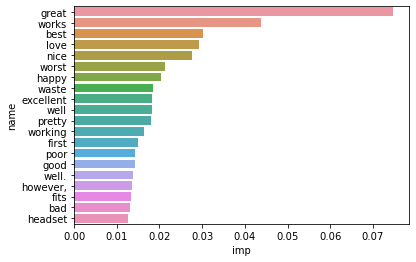

In [18]:
#feature_importances
feature_imp = pd.DataFrame(data=list(zip(model.feature_importances_, X_test.columns)), columns=['imp', 'name'])
feature_imp.sort_values(by='imp', ascending=False, inplace=True)

sb.barplot(x=feature_imp.imp[0:20], y=feature_imp.name[0:20])


<AxesSubplot:xlabel='imp', ylabel='name'>

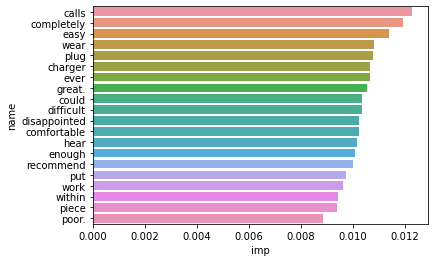

In [19]:
sb.barplot(x=feature_imp.imp[20:40], y=feature_imp.name[20:40])